<a href="https://colab.research.google.com/github/Valdi35/Detect-HFT-using-machine-learning-models/blob/main/Challenge_AMF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Le but du challenge est de construire un modèle de machine learning pouvant prédire les trois catégories de traders (HFT, non HFT et MIX). Au delà d'obtenir une meilleure accuracy, le second objectif consiste à choisir les variables les plus pertinentes.

In [1]:
#Install spark
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz
!tar -xvf spark-3.0.3-bin-hadoop2.7.tgz
!pip install -q findspark

spark-3.0.3-bin-hadoop2.7/
spark-3.0.3-bin-hadoop2.7/NOTICE
spark-3.0.3-bin-hadoop2.7/kubernetes/
spark-3.0.3-bin-hadoop2.7/kubernetes/tests/
spark-3.0.3-bin-hadoop2.7/kubernetes/tests/worker_memory_check.py
spark-3.0.3-bin-hadoop2.7/kubernetes/tests/py_container_checks.py
spark-3.0.3-bin-hadoop2.7/kubernetes/tests/pyfiles.py
spark-3.0.3-bin-hadoop2.7/kubernetes/dockerfiles/
spark-3.0.3-bin-hadoop2.7/kubernetes/dockerfiles/spark/
spark-3.0.3-bin-hadoop2.7/kubernetes/dockerfiles/spark/entrypoint.sh
spark-3.0.3-bin-hadoop2.7/kubernetes/dockerfiles/spark/bindings/
spark-3.0.3-bin-hadoop2.7/kubernetes/dockerfiles/spark/bindings/R/
spark-3.0.3-bin-hadoop2.7/kubernetes/dockerfiles/spark/bindings/R/Dockerfile
spark-3.0.3-bin-hadoop2.7/kubernetes/dockerfiles/spark/bindings/python/
spark-3.0.3-bin-hadoop2.7/kubernetes/dockerfiles/spark/bindings/python/Dockerfile
spark-3.0.3-bin-hadoop2.7/kubernetes/dockerfiles/spark/Dockerfile
spark-3.0.3-bin-hadoop2.7/jars/
spark-3.0.3-bin-hadoop2.7/jars/jacks

In [2]:
#Download libraries
import numpy as np
import pandas as pd
import io
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"
import findspark
findspark.init()
from google.colab import files
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import isnan, when, count, col, lit, trim, avg, ceil
from pyspark.sql.types import StringType
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyspark.sql import functions as F

In [3]:
#Data
uploaded = files.upload()

Saving AMF_test_X.csv to AMF_test_X.csv
Saving AMF_train_X.csv to AMF_train_X.csv
Saving AMF_train_Y.csv to AMF_train_Y.csv


In [4]:
sc = SparkSession.builder.master("local[*]").getOrCreate()

In [5]:
#Read data
df = sc.read.csv('AMF_train_X.csv', inferSchema=True, header=True)

#Lower columns names
for col in df.columns:
    df = df.withColumnRenamed(col, col.lower())

In [6]:
y_train = sc.read.csv('AMF_train_Y.csv', inferSchema=True, header=True)
for col in y_train.columns:
    y_train = y_train.withColumnRenamed(col, col.lower())

In [7]:
#Join the two df on trader id
data = df.join(y_train, on=("trader"))

List of features
x_Train and x_test data exhibit in their rows the same 35 features calculated for a given market player i on a certain stock Isin_iIsin 
i
​	
  (whose identification code is an Isin) and a specific trading date tt :


1 - number of trading venues on which the market player trades ;
from all trading venues, statistics over the number of trades observed per second : #2 the mean, and,
the max

2 - statistics over the observed time delta between two trades on the trading venue TV_1[1] :
min,
median,
min

3 - statistics over the observed time delta between two trades occurring on trading venue TV_1 and then on trading venue TV_2 :
min,
median,
min

4 - statistics over the observed time delta between two trades occurring on trading venue TV_1 and then on trading venue TV_3 :
min,
median,
min

5 - statistics over the observed time delta between two trades occurring on trading venue TV_1 and then on trading venue TV_4 :
min,
median,
min

6 - from all trading venues, number of seconds during the trading day where at least one trade of the market player i is observed
on trading venue TV_1, three ratios between the number of all types of events[2] sent to the LOB and :
the number of trades (OTR),
the number of cancellation-type event (OCR),
the number of modification-type event (OMR)

7 - on trading venue TV_1, statistics over the observed time delta between two all-type events sent :
min,
mean,
10th percentile,
1st quartile,
median,
3rd quartile,
90th percentile,
max

8 - on trading venue TV_1, statistics over the observed lifetime of cancelled orders :
min,
mean,
10th percentile,
1st quartile,
median,
3rd quartile,
90th percentile,
max

The features above are not detailed in the same order as in the challenge files.



[1] TV_1 is the trading venue with the highest volume traded
[2] Events include both the transactions and the messages that market players can send to the LOB: new order, order modification or order cancellation.

In [8]:
print(data.count())
print(data.columns)

105782
['trader', 'index', 'share', 'day', 'otr', 'ocr', 'omr', 'min_time_two_events', 'mean_time_two_events', '10_p_time_two_events', 'med_time_two_events', '25_p_time_two_events', '75_p_time_two_events', '90_p_time_two_events', 'max_time_two_events', 'min_lifetime_cancel', 'mean_lifetime_cancel', '10_p_lifetime_cancel', 'med_lifetime_cancel', '25_p_lifetime_cancel', '75_p_lifetime_cancel', '90_p_lifetime_cancel', 'max_lifetime_cancel', 'nbtradevenuemic', 'maxnbtradesbysecond', 'meannbtradesbysecond', 'min_dt_tv1', 'mean_dt_tv1', 'med_dt_tv1', 'min_dt_tv1_tv2', 'mean_dt_tv1_tv2', 'med_dt_tv1_tv2', 'min_dt_tv1_tv3', 'mean_dt_tv1_tv3', 'med_dt_tv1_tv3', 'min_dt_tv1_tv4', 'mean_dt_tv1_tv4', 'med_dt_tv1_tv4', 'nbsecondwithatleatonetrade', 'type']


In [9]:
#head 10 first value
print(data.show(10))

+---------+-----+--------+-------+------------------+------------------+------------------+-------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+-------------------+---------------+-------------------+--------------------+----------+------------------+-----------+--------------+---------------+--------------+--------------+---------------+--------------+--------------+---------------+--------------+--------------------------+-------+
|   trader|index|   share|    day|               otr|               ocr|               omr|min_time_two_events|mean_time_two_events|10_p_time_two_events|med_time_two_events|25_p_time_two_events|75_p_time_two_events|90_p_time_two_events|max_time_two_events|min_lifetime_cancel|mean_lifetime_cancel|10_p_life

In [10]:
print(data.printSchema())

root
 |-- trader: string (nullable = true)
 |-- index: integer (nullable = true)
 |-- share: string (nullable = true)
 |-- day: string (nullable = true)
 |-- otr: double (nullable = true)
 |-- ocr: double (nullable = true)
 |-- omr: double (nullable = true)
 |-- min_time_two_events: double (nullable = true)
 |-- mean_time_two_events: double (nullable = true)
 |-- 10_p_time_two_events: double (nullable = true)
 |-- med_time_two_events: double (nullable = true)
 |-- 25_p_time_two_events: double (nullable = true)
 |-- 75_p_time_two_events: double (nullable = true)
 |-- 90_p_time_two_events: double (nullable = true)
 |-- max_time_two_events: double (nullable = true)
 |-- min_lifetime_cancel: double (nullable = true)
 |-- mean_lifetime_cancel: double (nullable = true)
 |-- 10_p_lifetime_cancel: double (nullable = true)
 |-- med_lifetime_cancel: double (nullable = true)
 |-- 25_p_lifetime_cancel: double (nullable = true)
 |-- 75_p_lifetime_cancel: double (nullable = true)
 |-- 90_p_lifetime_

In [11]:
data = data.drop("index")

In [12]:
#Remove columns with null values more than a threeshold (0.2)
agg_row = data.select([(count(when(isnan(c) | F.col(c).isNull(), c))/data.count()).alias(c) for c in data.columns if c not in
                       {'day', 'trader', 'type', 'share'}]).collect()

In [13]:
agg_dict_list = [row.asDict() for row in agg_row]
agg_dict = agg_dict_list[0]

In [14]:
print(agg_dict)

{'otr': 0.015910079219526953, 'ocr': 0.0, 'omr': 0.4500954793821255, 'min_time_two_events': 0.0, 'mean_time_two_events': 0.0, '10_p_time_two_events': 0.0, 'med_time_two_events': 0.0, '25_p_time_two_events': 0.0, '75_p_time_two_events': 0.0, '90_p_time_two_events': 0.0, 'max_time_two_events': 0.0, 'min_lifetime_cancel': 0.0, 'mean_lifetime_cancel': 0.0, '10_p_lifetime_cancel': 0.0, 'med_lifetime_cancel': 0.0, '25_p_lifetime_cancel': 0.0, '75_p_lifetime_cancel': 0.0, '90_p_lifetime_cancel': 0.0, 'max_lifetime_cancel': 0.0, 'nbtradevenuemic': 0.0, 'maxnbtradesbysecond': 0.0, 'meannbtradesbysecond': 0.0, 'min_dt_tv1': 0.04003516666351553, 'mean_dt_tv1': 0.04003516666351553, 'med_dt_tv1': 0.04003516666351553, 'min_dt_tv1_tv2': 0.23799890340511617, 'mean_dt_tv1_tv2': 0.23799890340511617, 'med_dt_tv1_tv2': 0.23799890340511617, 'min_dt_tv1_tv3': 0.2387457223346127, 'mean_dt_tv1_tv3': 0.2387457223346127, 'med_dt_tv1_tv3': 0.2387457223346127, 'min_dt_tv1_tv4': 0.23773420808833262, 'mean_dt_tv1_t

In [15]:
col_null = list({i for i in agg_dict if agg_dict[i] > 0.2})
print(col_null)
data = data.drop(*col_null)

['mean_dt_tv1_tv3', 'min_dt_tv1_tv3', 'med_dt_tv1_tv4', 'mean_dt_tv1_tv2', 'med_dt_tv1_tv3', 'omr', 'min_dt_tv1_tv2', 'med_dt_tv1_tv2', 'mean_dt_tv1_tv4', 'min_dt_tv1_tv4']


Cross tables 

In [16]:
data.groupBy('day').count().orderBy('day', ascending=False).show()

+-------+-----+
|    day|count|
+-------+-----+
| Date_9| 4853|
| Date_8| 4730|
| Date_7| 5034|
| Date_6| 4941|
| Date_5| 4993|
|Date_30| 4828|
|Date_29| 5030|
|Date_28| 4803|
|Date_27| 4649|
|Date_26| 4707|
|Date_25| 4775|
|Date_24| 4587|
|Date_23| 4744|
|Date_20| 4846|
| Date_2| 4824|
|Date_19| 4676|
|Date_18| 4583|
|Date_15| 4975|
|Date_13| 4931|
|Date_12| 4621|
+-------+-----+
only showing top 20 rows



In [17]:
#Number of trade by trader in each type
data.groupBy('type').pivot('trader').sum('otr').show()

+-------+-----------------+------------------+-----------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+------------------+----------------+------------------+-----------------+-----------------+------------------+------------------+------------------+-----------------+-----------------+------------------+-----------------+------------------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+-----------------+----------+-----------------+------------------+-----------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+

In [18]:
#Representation of each category
data.groupBy('type').count().orderBy('count', ascending=False).show()

+-------+-----+
|   type|count|
+-------+-----+
|    MIX|51483|
|    HFT|31950|
|NON HFT|22349|
+-------+-----+



In [ ]:
df = data.toPandas()

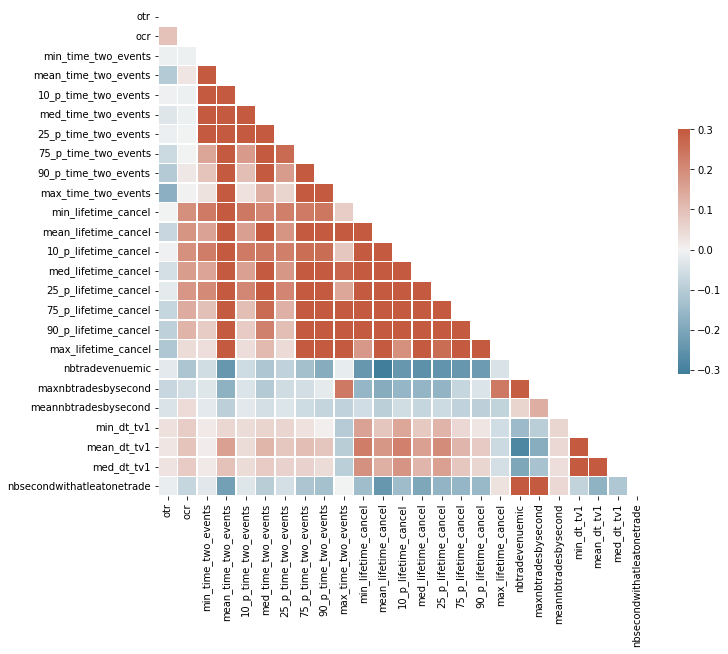

In [44]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [19]:
def correlation(dataset, threshold):
  ''' Remove correlated features, it will remove the first
  feature that is correlated with any other feature '''
  col_corr = set() #set of all highly correlated features
  corr_matrix = dataset.corr()
  for i in range(len(corr_matrix.columns)):
    for j in range(i):
      if abs(corr_matrix.iloc[i,j]) > threshold:
        colname = corr_matrix.columns[i]
        col_corr.add(colname)
  return col_corr

In [36]:
corr_features = correlation(df.iloc[:,~df.columns.isin(['day', 'trader', 'type', 'share'])], 0.7)

In [37]:
corr_features

{'10_p_lifetime_cancel',
 '10_p_time_two_events',
 '25_p_lifetime_cancel',
 '25_p_time_two_events',
 '75_p_lifetime_cancel',
 '75_p_time_two_events',
 '90_p_lifetime_cancel',
 '90_p_time_two_events',
 'max_lifetime_cancel',
 'mean_dt_tv1',
 'mean_lifetime_cancel',
 'med_dt_tv1',
 'med_lifetime_cancel',
 'med_time_two_events'}

In [ ]:
#statistics calculated by AMF on lifetime cancel and time between two events have some redundant value and so, are highly correlated

In [48]:
#Drop correlated features
df = df.drop(corr_features,axis=1)

Explanatory data analysis

In [53]:
df = df.set_index('trader')

In [59]:
df = pd.DataFrame(data=df)